In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,AveragePooling1D,GlobalAveragePooling1D
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
start = dt.datetime(2000,1,1)

# endDate , as per our convenience we can modify
end = dt.datetime(2023,10,1)
startdate=end
company = input('STOCK : ')
df = yf.Ticker(company)

# pass the parameters as the taken dates for start and end
data =df.history(start=start,end=end)

# np.random.seed(42)  # Set seed for NumPy
# tf.random.set_seed(42)  # Set seed for TensorFlow
data.head(5)

STOCK : BNB-USD


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,2.05314,2.17423,1.89394,1.99077,19192200,0.0,0.0
2017-11-10 00:00:00+00:00,2.00773,2.06947,1.64478,1.79684,11155000,0.0,0.0
2017-11-11 00:00:00+00:00,1.78628,1.91775,1.61429,1.67047,8178150,0.0,0.0
2017-11-12 00:00:00+00:00,1.66889,1.67280,1.46256,1.51969,15298700,0.0,0.0
2017-11-13 00:00:00+00:00,1.52601,1.73502,1.51760,1.68662,12238800,0.0,0.0


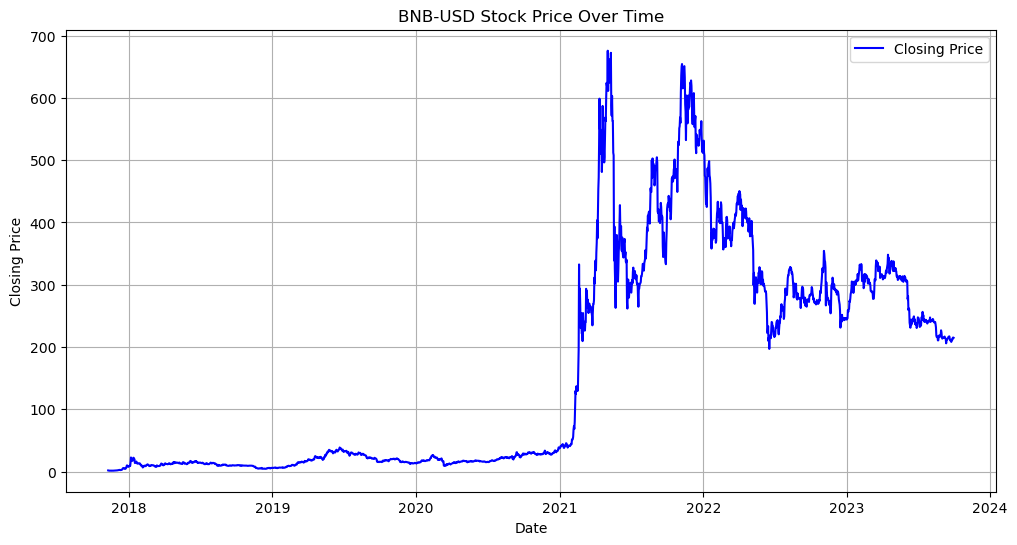

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.title(f'{company} Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
data.shape

(2152, 7)

In [5]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [9]:
def preprocess_data(data, target_col, sequence_length=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[[target_col]])

    features, targets = [], []

    for i in range(len(data_scaled) - sequence_length):
        features.append(data_scaled[i:i + sequence_length])
        targets.append(data_scaled[i + sequence_length])

    features, targets = np.array(features), np.array(targets)

    return features, targets, scaler

# Function to build the CNN model
def build_model(input_shape, num_conv_layers=1, num_filters=64, kernel_size=2,num_dense_layers=2, num_neurons=[50, 30]):
    model = Sequential()
    for _ in range(num_conv_layers):
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
        model.add(AveragePooling1D(pool_size=2))
    model.add(Flatten())
    # Add more dense layers based on num_dense_layers
    for i in range(num_dense_layers):
        model.add(Dense(num_neurons[i], activation='relu'))
#     model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Function to train the model
def train_model(model, X_train, y_train, epochs=100, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Preprocess data
target_col = 'Close'
sequence_length = 10
features, targets, scaler = preprocess_data(data, target_col, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Build and train the model
input_shape = (X_train.shape[1], 1)
model = build_model(input_shape, num_conv_layers=2, num_filters=128, kernel_size=3,num_dense_layers=2, num_neurons=[50, 30])
train_model(model, X_train, y_train)

predictions = make_predictions(model, X_test, scaler)

# Evaluate the model
mse = np.mean(np.square(predictions - scaler.inverse_transform(y_test)))
print(f'Mean Squared Error: {mse}')

Epoch 1/100
54/54 [==============================] - 2s 8ms/step - loss: 0.0155
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 4/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 7/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 8/100
54/54 [==============================] - 0s 5ms/step - loss: 8.8600e-04
Epoch 9/100
54/54 [==============================] - 0s 5ms/step - loss: 8.7460e-04
Epoch 10/100
54/54 [==============================] - 0s 5ms/step - loss: 7.8830e-04
Epoch 11/100
54/54 [==============================] - 0s 5ms/step - loss: 9.8768e-04
Epoch 12/100
54/54 [==============================] - 0s 5ms/step - loss: 9.4965e-04
Epoch 13/100
54/5

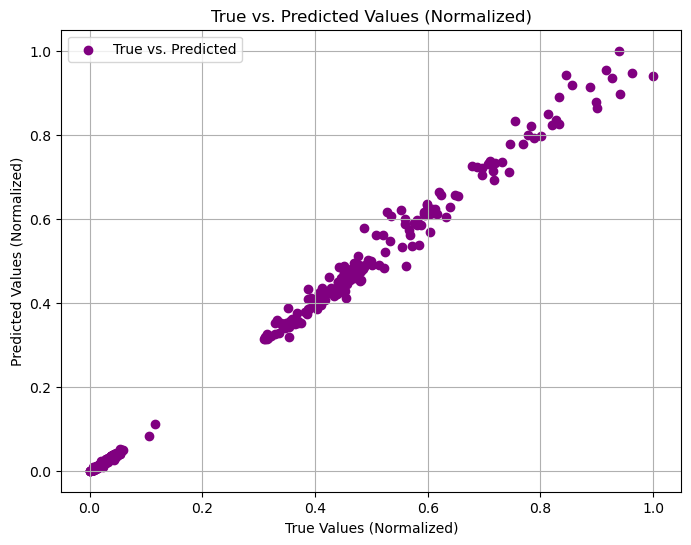

In [10]:
y_test_normalized = (y_test - y_test.min()) / (y_test.max() - y_test.min())
y_pred_normalized = (predictions - predictions.min()) / (predictions.max() - predictions.min())

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_normalized, y_pred_normalized, c='purple', label='True vs. Predicted')
plt.title('True vs. Predicted Values (Normalized)')
plt.xlabel('True Values (Normalized)')
plt.ylabel('Predicted Values (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
error_percentage = np.mean(np.abs(predictions - scaler.inverse_transform(y_test)) / scaler.inverse_transform(y_test)) * 100
print(f'Error Percentage: {error_percentage:.2f}%')

accuracy_percentage = 100 - error_percentage
print(f'Accuracy Percentage: {accuracy_percentage:.2f}%')

Error Percentage: 8.13%
Accuracy Percentage: 91.87%


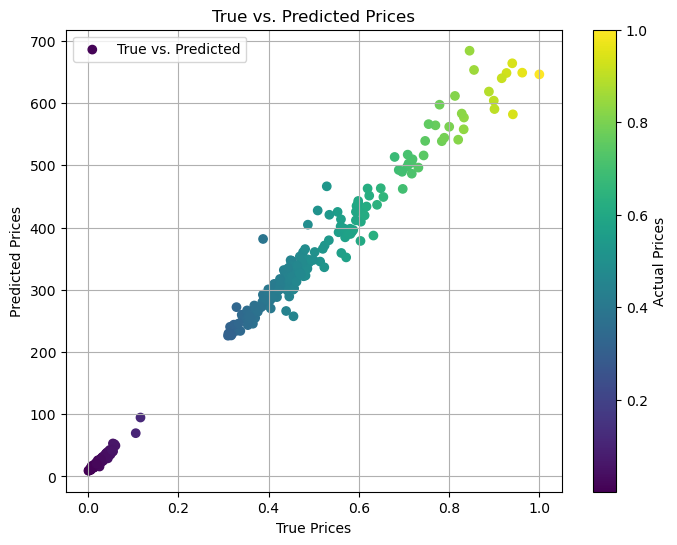

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, c=y_test.flatten(), cmap='viridis', label='True vs. Predicted')
plt.colorbar().set_label('Actual Prices')
plt.title('True vs. Predicted Prices')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()


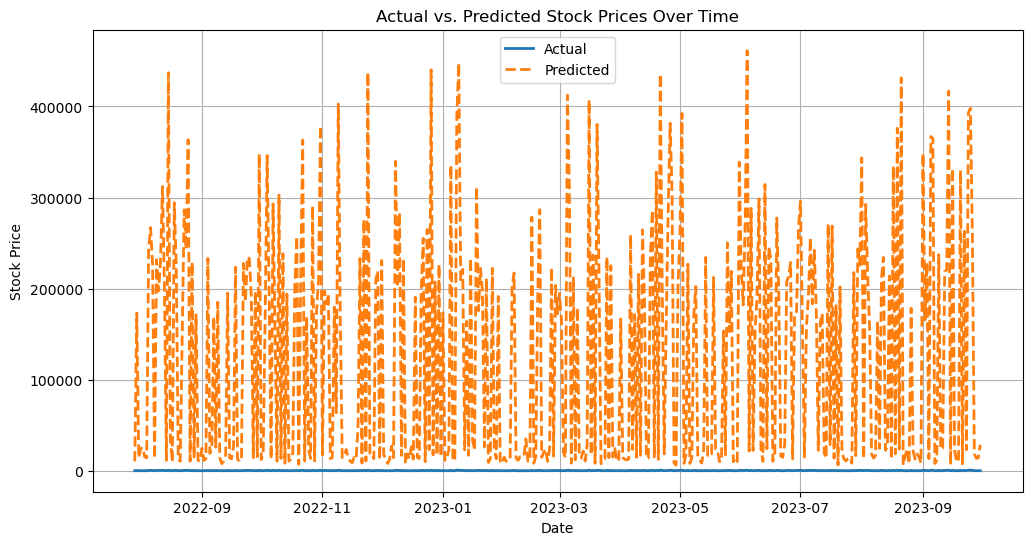

In [9]:
# Convert predictions and y_test back to the original scale
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_original_scale):], y_test_original_scale, label='Actual', linewidth=2)
plt.plot(data.index[-len(predictions_original_scale):], predictions_original_scale, label='Predicted', linestyle='dashed', linewidth=2)
plt.title('Actual vs. Predicted Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
